<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

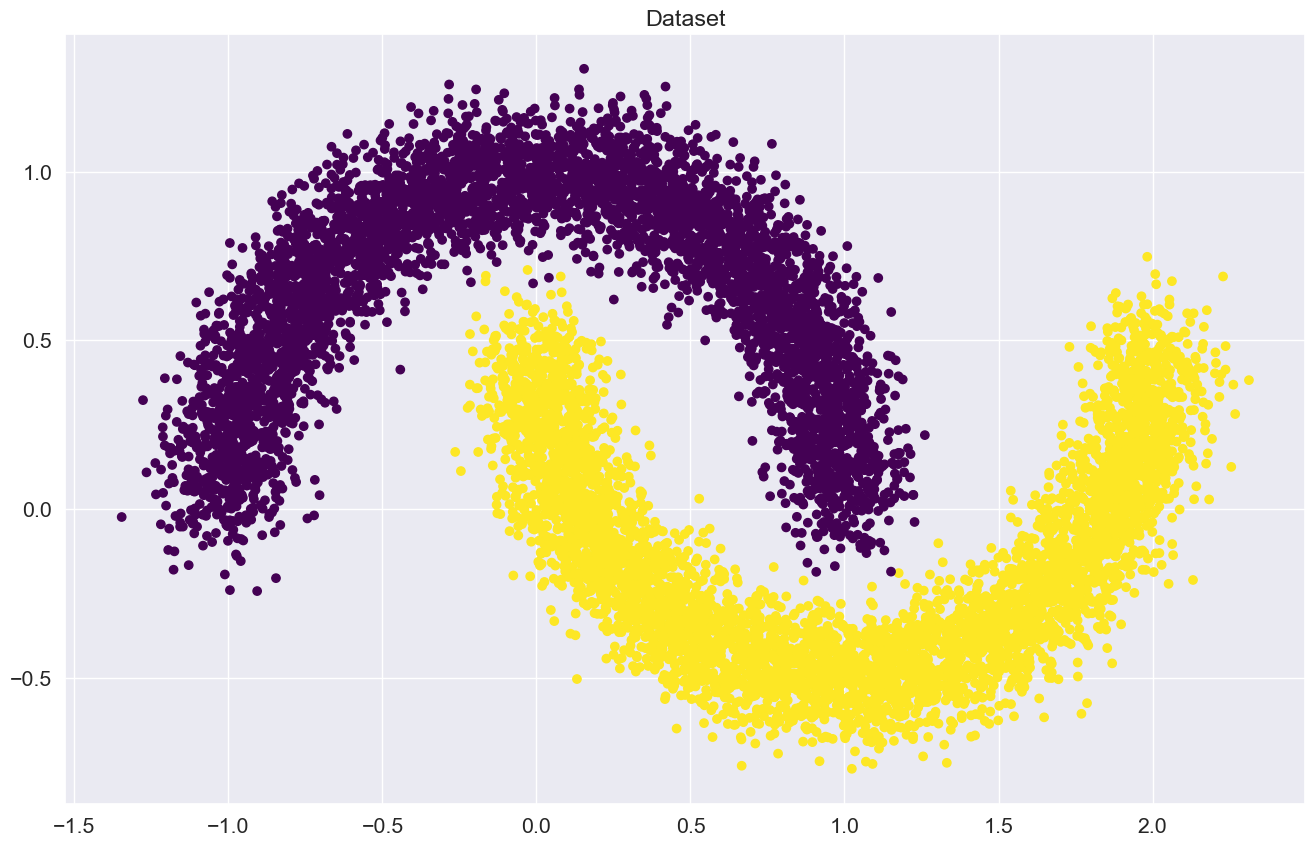

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.from_numpy(X_train).to(torch.float32) 
y_train_t = torch.from_numpy(y_train).to(torch.float32) 
X_val_t = torch.from_numpy(X_val).to(torch.float32) 
y_val_t = torch.from_numpy(y_val).to(torch.float32) 

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, 1))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1)) 

    def forward(self, x):
        x = x@self.weights
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(linear_regression)

3

## Ответ на вопрос 1: 3 параметра

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch) # YOUR CODE. Use linear_regression to get outputs
        y_batch = y_batch.view(-1, 1)
        loss = loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = F.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 64.65625
Iteration: 100
Batch accuracy: 64.0
Iteration: 200
Batch accuracy: 64.3125
Iteration: 300
Batch accuracy: 64.3125
Iteration: 400
Batch accuracy: 64.140625
Iteration: 500
Batch accuracy: 64.046875
Iteration: 600
Batch accuracy: 66.0625
Iteration: 700
Batch accuracy: 63.78125
Iteration: 800
Batch accuracy: 64.125
Iteration: 900
Batch accuracy: 63.6875

Iteration: 991.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 519 итераций

## Ответ на вопрос 2: 519 итераций потребовалось что бы алгоритм сошелся

### Визуализируем результаты

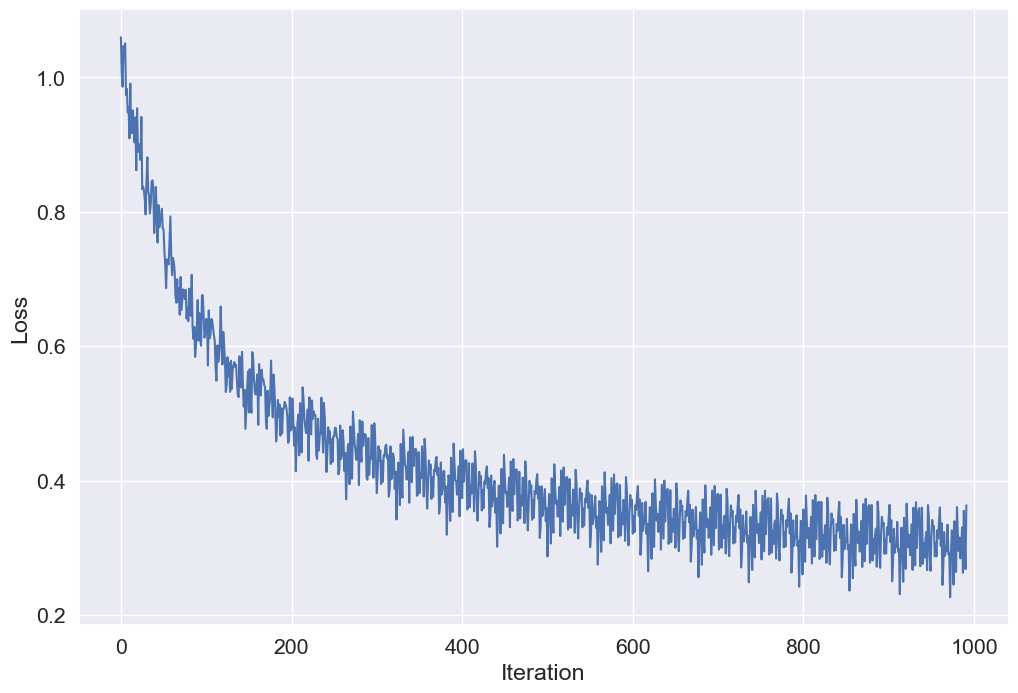

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

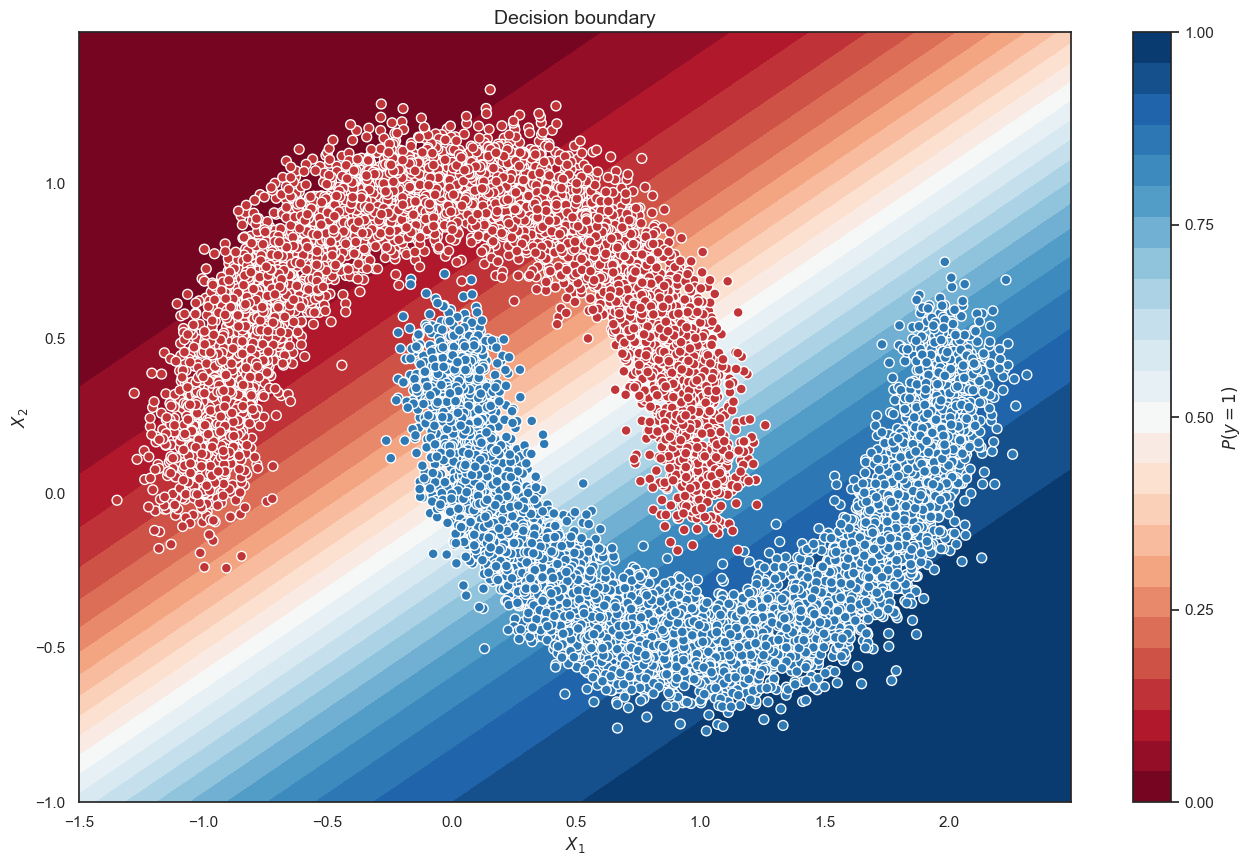

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model.forward(x_batch) #YOUR CODE. Compute predictions
        preds = (F.sigmoid(preds) > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()


In [14]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

0.8564

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8672

## Ответ на вопрос 3: Получившееся значение метрики accuracy 0.8672

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [15]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2) # YOUR CODE GOES HERE
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2) # YOUR CODE GOES HERE

In [16]:
for _ in valid_dataloader:
    print(_[0].shape)
    break

torch.Size([4, 1, 28, 28])


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [18]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation,
    nn.Linear(128,128),
    activation,
    nn.Linear(128, 10)
)

In [19]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [21]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()  # YOUR CODE GOES HERE
            all = y_batch.shape[0]  # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9075666666666666
Loader: valid. Accuracy: 0.9454
Epoch: 2
Loader: train. Accuracy: 0.9469333333333333
Loader: valid. Accuracy: 0.9449
Epoch: 3
Loader: train. Accuracy: 0.9557166666666667
Loader: valid. Accuracy: 0.9591
Epoch: 4
Loader: train. Accuracy: 0.9601666666666666
Loader: valid. Accuracy: 0.9593
Epoch: 5
Loader: train. Accuracy: 0.9632166666666667
Loader: valid. Accuracy: 0.9644
Epoch: 6
Loader: train. Accuracy: 0.9649666666666666
Loader: valid. Accuracy: 0.9457
Epoch: 7
Loader: train. Accuracy: 0.9669166666666666
Loader: valid. Accuracy: 0.9672
Epoch: 8
Loader: train. Accuracy: 0.968
Loader: valid. Accuracy: 0.9628
Epoch: 9
Loader: train. Accuracy: 0.9698833333333333
Loader: valid. Accuracy: 0.9677
Epoch: 10
Loader: train. Accuracy: 0.9713666666666667
Loader: valid. Accuracy: 0.9607


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [22]:
elu_accuracy = accuracy["valid"]

In [23]:
elu_accuracy

[0.9454,
 0.9449,
 0.9591,
 0.9593,
 0.9644,
 0.9457,
 0.9672,
 0.9628,
 0.9677,
 0.9607]

In [24]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation: str):
    if activation == "Identical":
        activation = nn.Identity()
    elif activation == "RELU":
        activation = nn.ReLU()
    elif activation == "LeakyReLU":
        activation = nn.LeakyReLU(0.1)
    else:
        raise print("Unsupported activation function. Only functions Identical, RELU, LeakyReLU are supported.")
    
    model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(28*28, 128),
                activation,
                nn.Linear(128,128),
                activation,
                nn.Linear(128, 10)
            )

    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.shape[0]
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [25]:
plain_accuracy = test_activation_function("Identical")
relu_accuracy = test_activation_function("RELU")
leaky_relu_accuracy = test_activation_function("LeakyReLU")

Epoch: 1
Loader: train. Accuracy: 0.8483833333333334
Loader: valid. Accuracy: 0.8506
Epoch: 2
Loader: train. Accuracy: 0.8822833333333333
Loader: valid. Accuracy: 0.906
Epoch: 3
Loader: train. Accuracy: 0.8893
Loader: valid. Accuracy: 0.8927
Epoch: 4
Loader: train. Accuracy: 0.8919833333333334
Loader: valid. Accuracy: 0.8882
Epoch: 5
Loader: train. Accuracy: 0.8952
Loader: valid. Accuracy: 0.8971
Epoch: 6
Loader: train. Accuracy: 0.8982333333333333
Loader: valid. Accuracy: 0.9028
Epoch: 7
Loader: train. Accuracy: 0.8988833333333334
Loader: valid. Accuracy: 0.9053
Epoch: 8
Loader: train. Accuracy: 0.9003666666666666
Loader: valid. Accuracy: 0.9032
Epoch: 9
Loader: train. Accuracy: 0.90065
Loader: valid. Accuracy: 0.8914
Epoch: 10
Loader: train. Accuracy: 0.9021333333333333
Loader: valid. Accuracy: 0.8991
Epoch: 1
Loader: train. Accuracy: 0.90145
Loader: valid. Accuracy: 0.9379
Epoch: 2
Loader: train. Accuracy: 0.9404166666666667
Loader: valid. Accuracy: 0.95
Epoch: 3
Loader: train. Accu

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

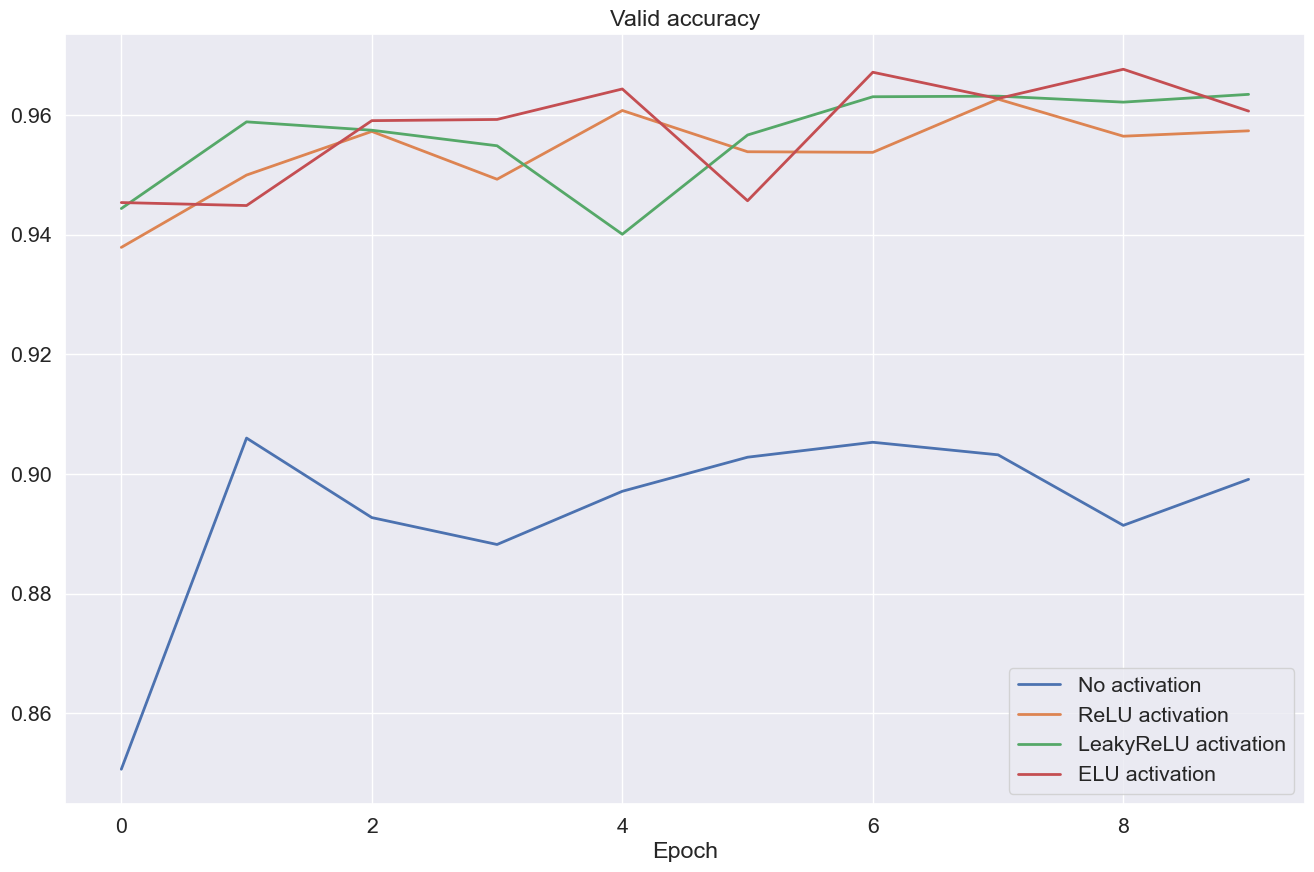

In [26]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

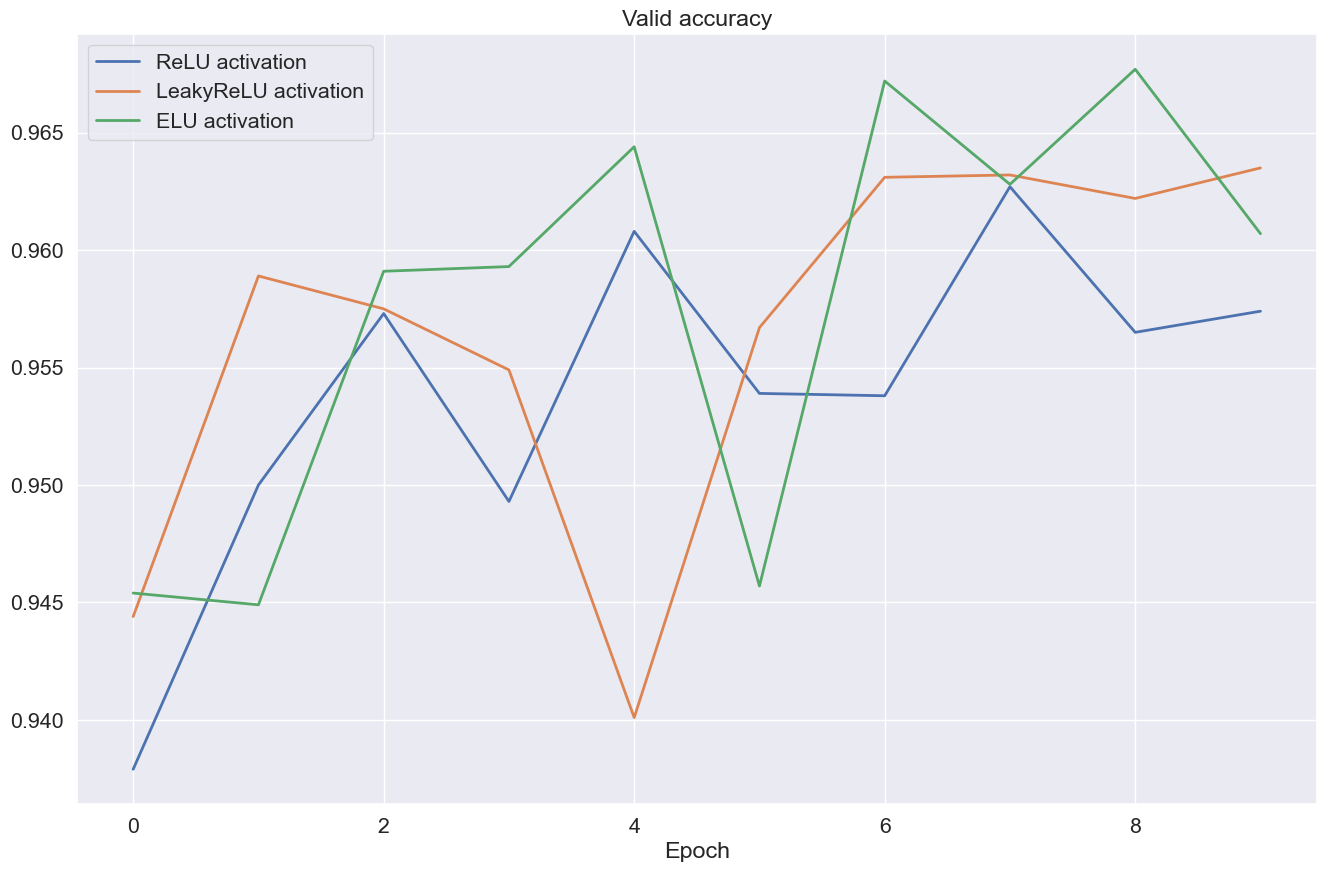

In [27]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [28]:
activation_fncts_max = {"No activation": max(plain_accuracy),
"ReLU activation": max(relu_accuracy),
"ELU activation": max(elu_accuracy),
"LeakyReLU activation": max(leaky_relu_accuracy)}

max_acc_fnct = max(activation_fncts_max.items(), key=(lambda key: activation_fncts_max[key[0]]))

print(f"Activation funct: {max_acc_fnct[0]}, max accurace value: {max_acc_fnct[1]}")

activation_fncts_max_last_step = {"No activation": plain_accuracy[-1],
"ReLU activation": relu_accuracy[-1],
"ELU activation": elu_accuracy[-1],
"LeakyReLU activation": leaky_relu_accuracy[-1]}


max_last_step_acc_fnct = max(activation_fncts_max_last_step.items(), key=(lambda key: activation_fncts_max_last_step[key[0]]))
print(f"Activation funct: {max_last_step_acc_fnct[0]}, max last step accurace value: {max_last_step_acc_fnct[1]}")

Activation funct: ELU activation, max accurace value: 0.9677
Activation funct: LeakyReLU activation, max last step accurace value: 0.9635


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** К концу обучения (те на последнем шаге) лучшее значение метрики accuracy было у функции активации ReLU с итоговой цифрой в 0.9642. При этом максимальное значение метрики accuracy на всем цикле обучения было у функции активации ELU. Которое составило: 0.9697

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [29]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-07-01 23:08:53--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village.kz (img.the-village.kz)… 5.9.226.237
Подключение к img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 49337 (48K) [image/jpeg]
Сохранение в: «sample_photo.jpg»

sample_photo.jpg    100%[===================>]  48,18K   174KB/s    за 0,3s    

2024-07-01 23:08:54 (174 KB/s) - «sample_photo.jpg» сохранён [49337/49337]



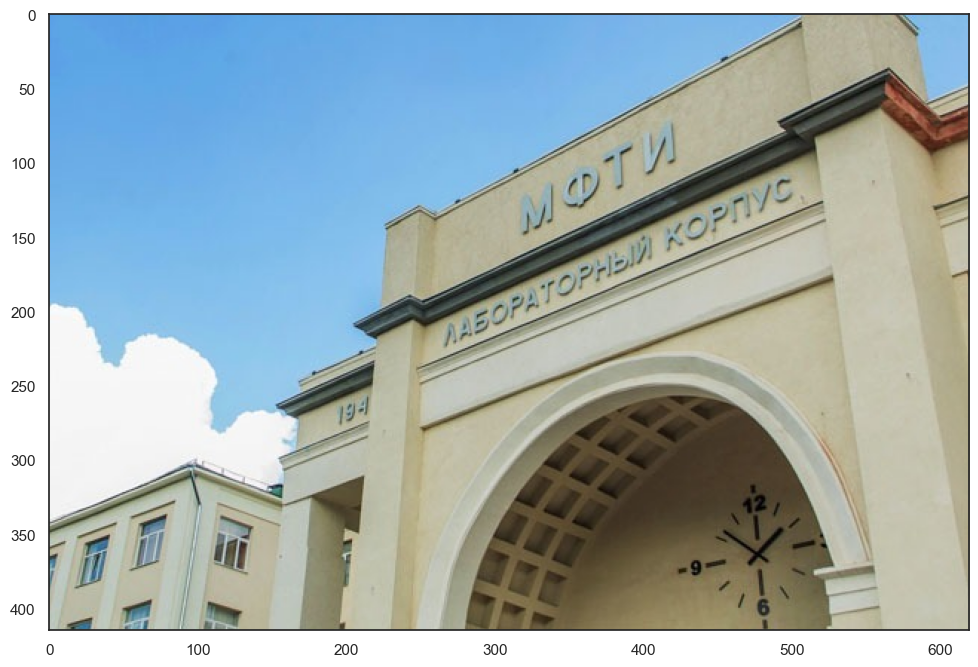

In [30]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [31]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76692706..0.81901044].


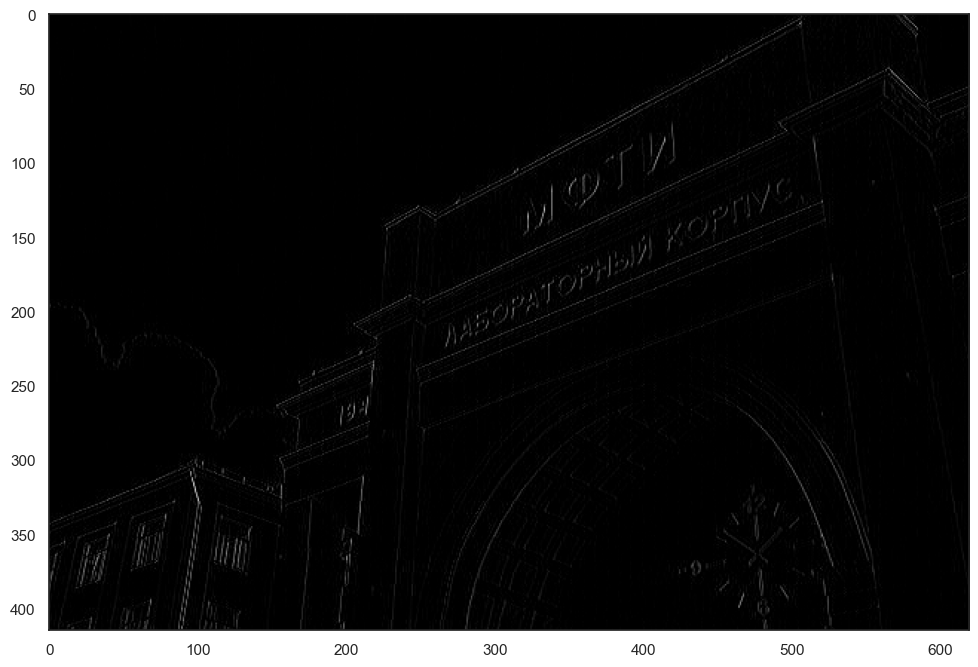

In [32]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

In [33]:
titles = {"А": [[0, 0, 0],[0, 1, 0],[0, 0, 0]], "Б": [[0, 1, 0],[0, -2, 0],[0, 1, 0]], "В": [[0, 0, 0],[1, -2, 1],[0, 0, 0]],
         "Г": [[0, 1, 0],[1, -4, 1],[0, 1, 0]], "Д": [[0, -1, 0],[-1, 5, -1],[0, -1, 0]], "Е": [[0.0625, 0.125, 0.0625],[0.125, 0.25, 0.125],[0.0625, 0.125, 0.0625]]}

In [34]:
output_imgs = []
for k,v in titles.items():
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(v).reshape(1, 1, 3, 3).type(torch.float32)
    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
    result = F.conv2d(img_t, kernel)[0]
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3
    output_imgs.append([result_np, k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79296875..1.0351562].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76692706..0.81901044].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1679688..1.4140625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2005209..2.0546875].


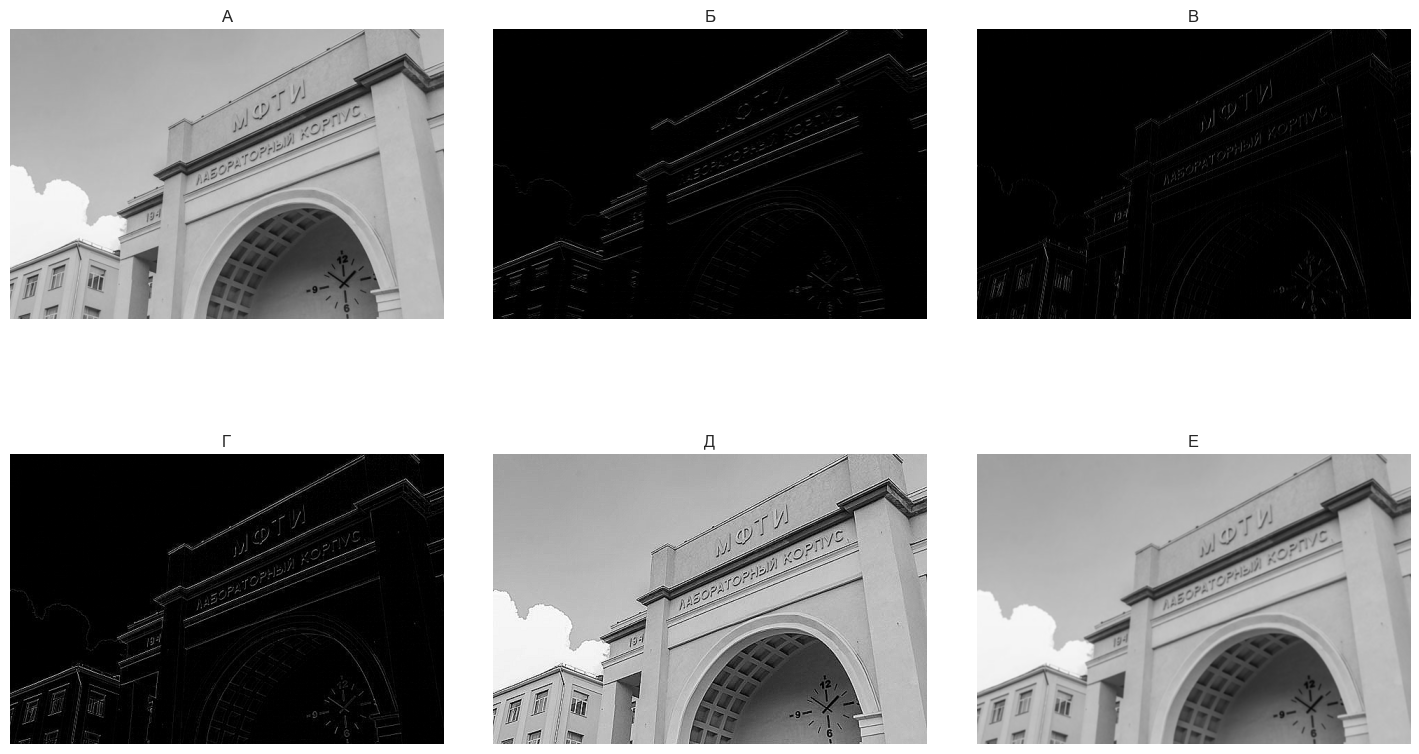

In [35]:
# Создаем фигуру и оси для шести подграфиков
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Итерация по осям и данным для отображения графиков
for ax, (image, title) in zip(axes.flatten(), output_imgs):
    ax.imshow(image)  # Отображение изображения
    ax.set_title(title)            # Установка заголовка
    ax.axis('off')     

# Добавляем отступы между подграфиками
fig.tight_layout(pad=3.0)

# Отображаем графики
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

1) Размытие -> Е
2) Увеличение резкости -> Д
3) Тождественное преобразование -> А
4) Выделение вертикальных границ -> В
5) Выделение горизонтальных границ -> Б
6) Выделение границ -> Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [75]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7744, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [77]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9635833333333333
Loader: valid. Accuracy: 0.9826
Epoch: 2
Loader: train. Accuracy: 0.9837333333333333
Loader: valid. Accuracy: 0.9855
Epoch: 3
Loader: train. Accuracy: 0.9880666666666666
Loader: valid. Accuracy: 0.9868
Epoch: 4
Loader: train. Accuracy: 0.9907
Loader: valid. Accuracy: 0.9881
Epoch: 5
Loader: train. Accuracy: 0.9918333333333333
Loader: valid. Accuracy: 0.9883
Epoch: 6
Loader: train. Accuracy: 0.9928333333333333
Loader: valid. Accuracy: 0.9876
Epoch: 7
Loader: train. Accuracy: 0.9938833333333333
Loader: valid. Accuracy: 0.9855
Epoch: 8
Loader: train. Accuracy: 0.9941833333333333
Loader: valid. Accuracy: 0.9857
Epoch: 9
Loader: train. Accuracy: 0.99465
Loader: valid. Accuracy: 0.9796
Epoch: 10
Loader: train. Accuracy: 0.99515
Loader: valid. Accuracy: 0.9877


In [78]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

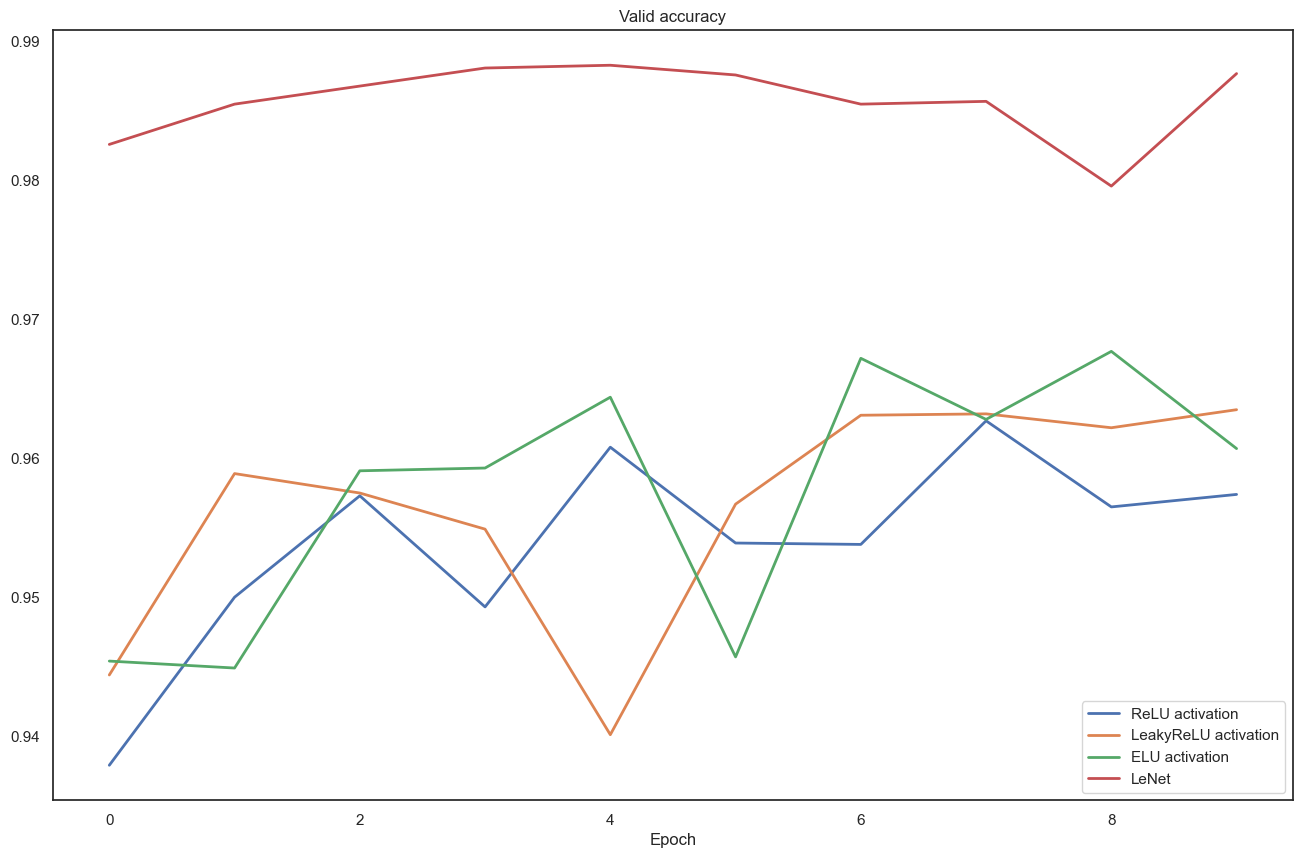

In [79]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** Итоговая метрика получилась равной 0.98